In [45]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [46]:
def resize_image(img, new_size=(256, 256)):
    return cv.resize(img, new_size)

In [47]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [48]:
images, filenames, labels, path, distribusi = insertGambar("dataset/dataset/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne vulgaris


100%|██████████| 100/100 [00:01<00:00, 52.93it/s]


Rosacea


100%|██████████| 100/100 [00:01<00:00, 52.57it/s]

Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne vulgaris': 100, 'Rosacea': 100}


In [49]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [50]:
def equalize_histogram(img):
    return cv.equalizeHist(img)

In [51]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [52]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [53]:
def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

In [54]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [55]:
def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

In [56]:
import numpy as np

def manual_clahe(gray_img: np.ndarray, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    h, w = gray_img.shape
    n_tiles_x, n_tiles_y = tile_grid_size
    tile_h = h // n_tiles_y
    tile_w = w // n_tiles_x
    bins = 256
    
    # Hitung clip limit aktual dalam jumlah pixel
    tile_size = tile_h * tile_w
    clip_limit_pixel = int((clip_limit * tile_size) / bins)
    
    # Buat hasil yang akan diisi
    result = np.zeros_like(gray_img, dtype=np.uint8)
    
    # Simpan semua mapping untuk setiap tile
    maps = np.zeros((n_tiles_y, n_tiles_x, bins), dtype=np.uint8)

    # Hitung histogram & mapping untuk tiap tile
    for i in range(n_tiles_y):
        for j in range(n_tiles_x):
            y0, y1 = i * tile_h, (i + 1) * tile_h
            x0, x1 = j * tile_w, (j + 1) * tile_w
            tile = gray_img[y0:y1, x0:x1]
            
            hist, _ = np.histogram(tile, bins=bins, range=(0, 256))
            
            # Clipping
            excess = np.maximum(hist - clip_limit_pixel, 0)
            clipped_hist = hist.copy()
            clipped_hist[clipped_hist > clip_limit_pixel] = clip_limit_pixel
            redistribute = np.sum(excess) // bins
            clipped_hist += redistribute
            
            # Hitung CDF
            cdf = np.cumsum(clipped_hist)
            cdf_min = cdf.min()
            cdf_range = cdf.max() - cdf_min
            if cdf_range == 0:
                cdf_range = 1
            mapping = ((cdf - cdf_min) * 255 / cdf_range).astype(np.uint8)
            maps[i, j] = mapping
    
    # Interpolasi antar tile
    for i in range(h):
        for j in range(w):
            # Posisi relatif di grid tile
            y_frac = (i + 0.5) / tile_h - 0.5
            x_frac = (j + 0.5) / tile_w - 0.5

            y = int(np.floor(y_frac))
            x = int(np.floor(x_frac))

            y = max(0, min(y, n_tiles_y - 2))
            x = max(0, min(x, n_tiles_x - 2))

            dy = y_frac - y
            dx = x_frac - x

            val = gray_img[i, j]

            # Ambil 4 tetangga mapping
            m00 = maps[y, x, val]
            m01 = maps[y, x + 1, val]
            m10 = maps[y + 1, x, val]
            m11 = maps[y + 1, x + 1, val]

            # Bilinear interpolation
            top = (1 - dx) * m00 + dx * m01
            bottom = (1 - dx) * m10 + dx * m11
            interpolated_val = (1 - dy) * top + dy * bottom
            result[i, j] = np.clip(int(round(interpolated_val)), 0, 255)


    return result


In [ ]:
def haar_1d_transform(vector):
    h_low = [1/np.sqrt(2), 1/np.sqrt(2)]
    h_high = [-1/np.sqrt(2), 1/np.sqrt(2)]

    approx = []
    detail = []
    for i in range(0, len(vector) - 1, 2):
        a = vector[i] * h_low[0] + vector[i + 1] * h_low[1]
        d = vector[i] * h_high[0] + vector[i + 1] * h_high[1]
        approx.append(a)
        detail.append(d)
    return approx, detail

def wavelet_transform(image):
    image = image.astype(float)  

    #Transformasi baris
    row_approx = []
    row_detail = []
    for row in image:
        a, d = haar_1d_transform(row)
        row_approx.append(a)
        row_detail.append(d)
    
    row_approx = np.array(row_approx)
    row_detail = np.array(row_detail)

    #Transformasi kolom
    LL, HL = [], []
    for col in row_approx.T:
        a, d = haar_1d_transform(col)
        LL.append(a)
        HL.append(d)
    
    LH, HH = [], []
    for col in row_detail.T:
        a, d = haar_1d_transform(col)
        LH.append(a)
        HH.append(d)
    
    LL = np.array(LL).T
    LH = np.array(LH).T
    HL = np.array(HL).T
    HH = np.array(HH).T

    return LL, LH, HL, HH


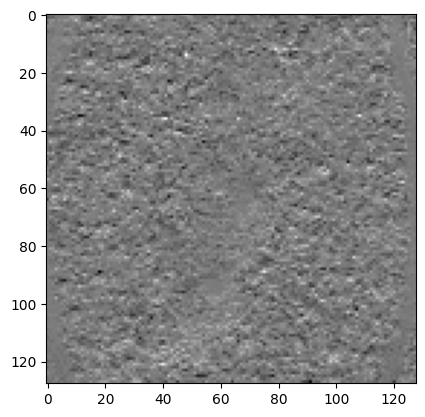

In [92]:
resize_img = resize_image(images[1])  
gray_img = gray_scaling(resize_img)  
citra_clahe = manual_clahe(gray_img, 5, (4, 4))
medianData = median_filtering(citra_clahe)
LL, LH, HL, HH = wavelet_transform(medianData) 
glcm_input = HL  
normalizeData = normalize(glcm_input)

plt.imshow(normalizeData, cmap="gray")

In [ ]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    citra_clahe = manual_clahe(gray_img, 5, (4, 4))
    medianData = median_filtering(citra_clahe)
    LL, LH, HL, HH = wavelet_transform(medianData) 
    glcm_input = HL  
    normalizeData = normalize(glcm_input)  

    dataPreprocessed.append(normalizeData)

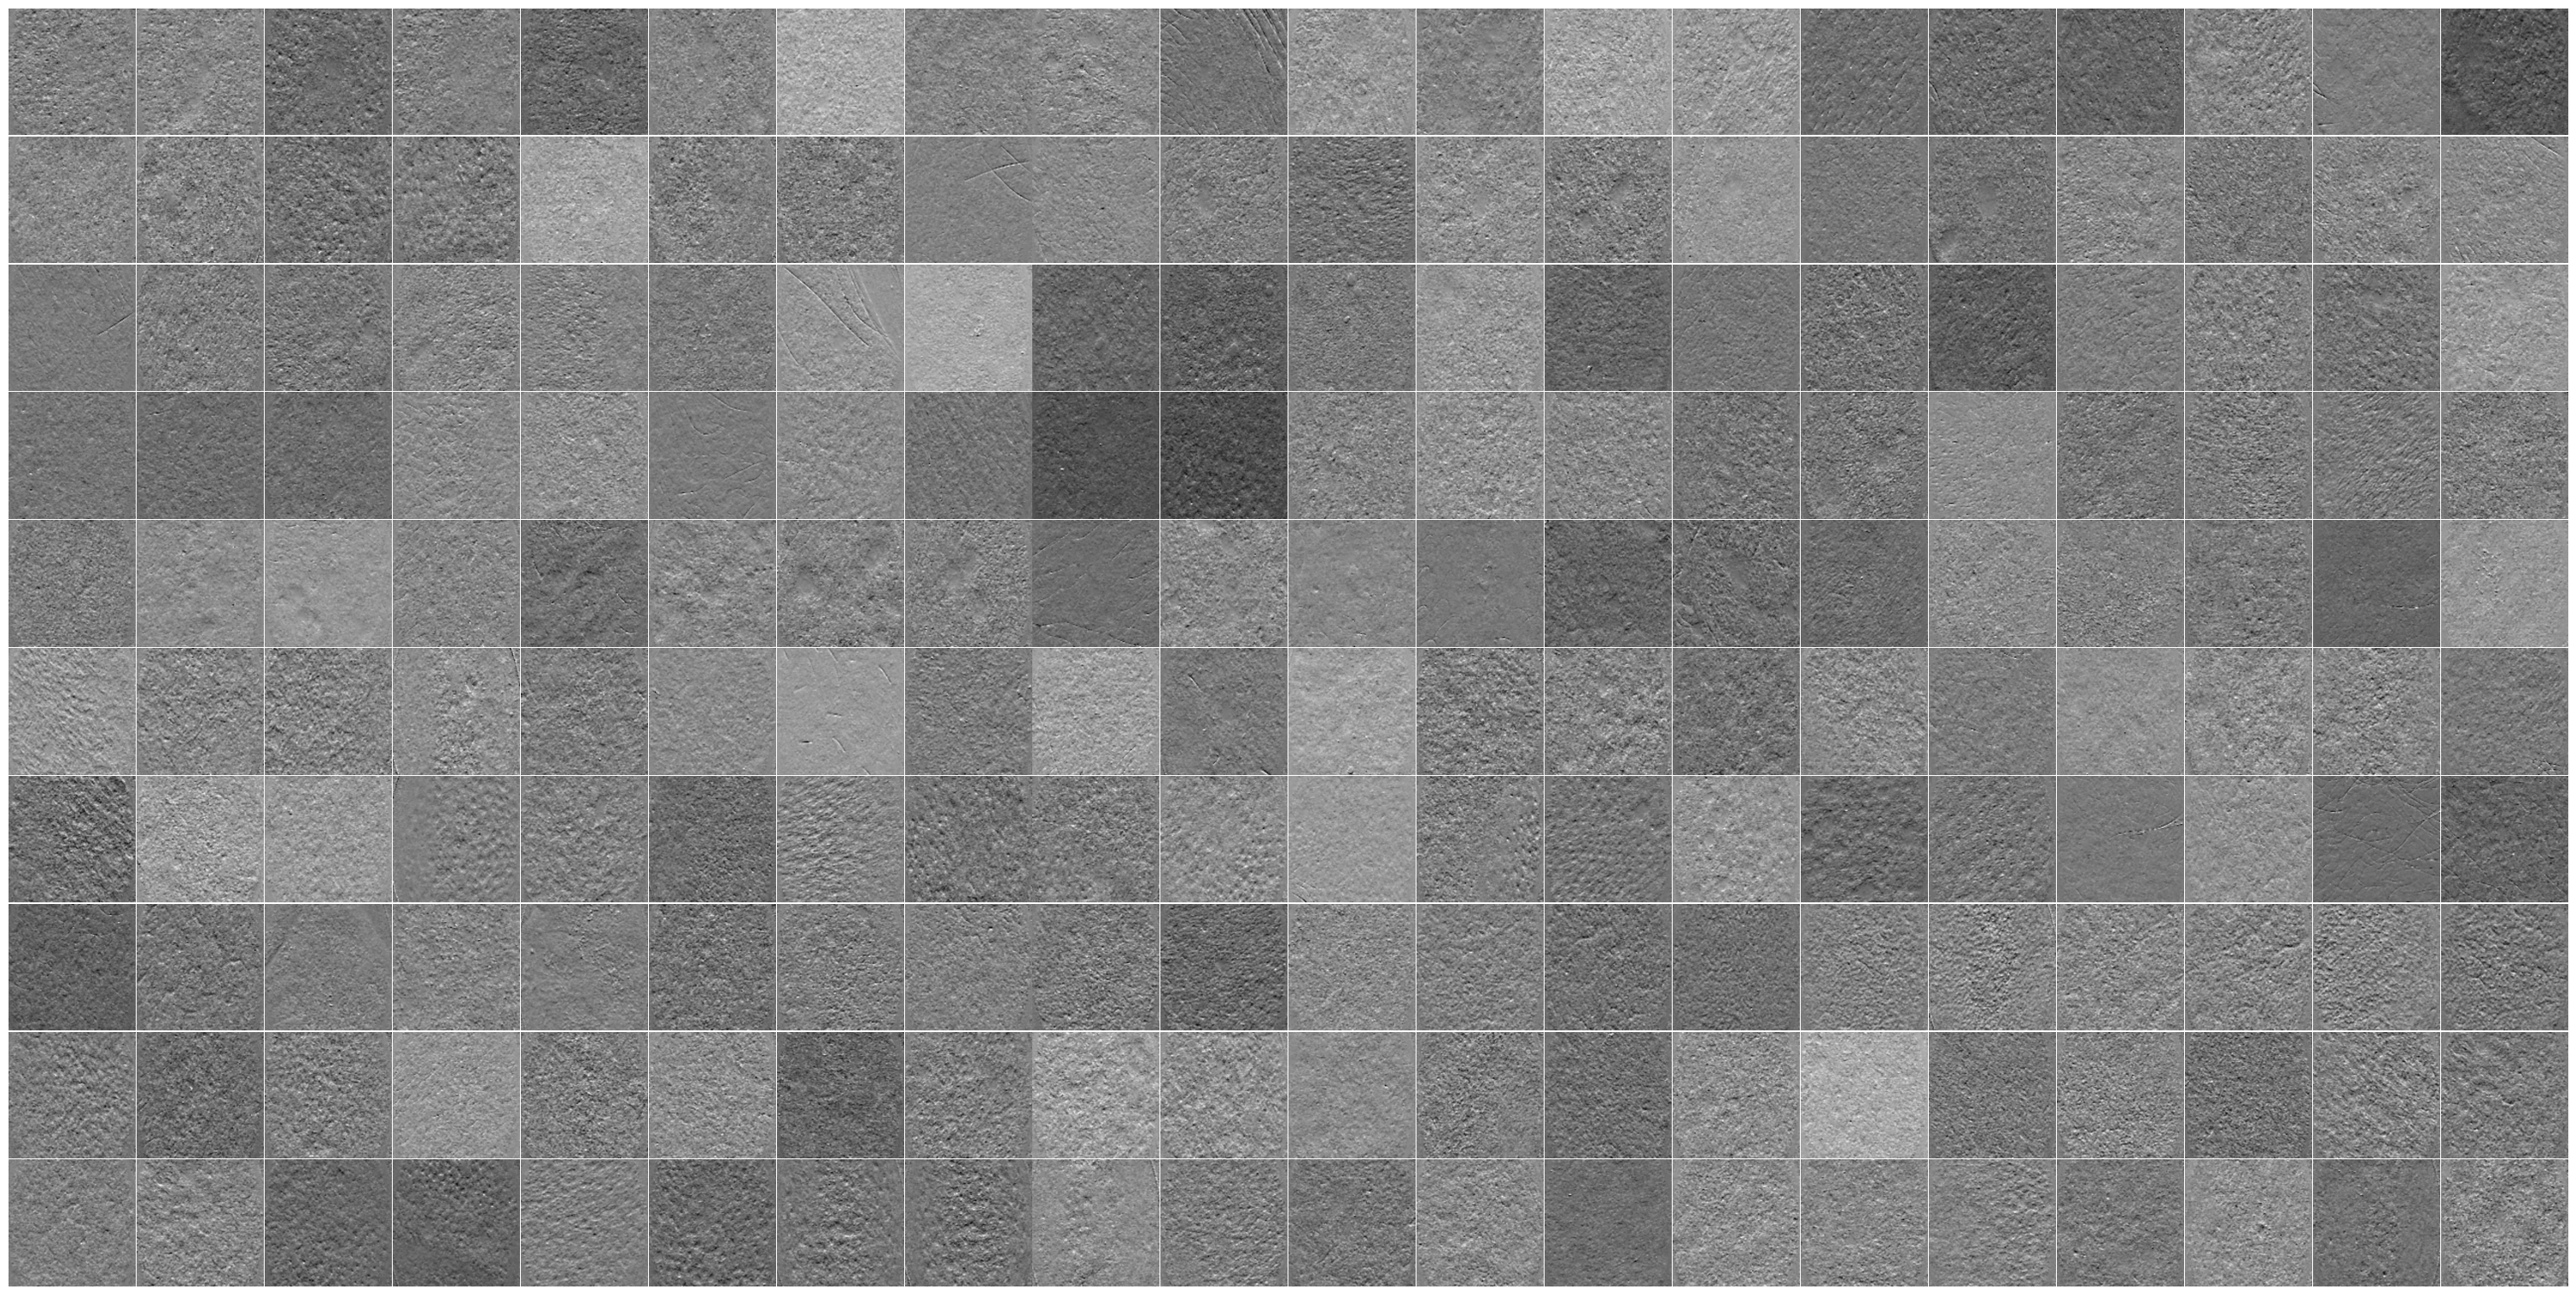

In [60]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

In [61]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [62]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [63]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [64]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [65]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [66]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [67]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [68]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [69]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [70]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [71]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [72]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [73]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [74]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [75]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [76]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [77]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [78]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


In [79]:
print(df.describe())  # Lihat ringkasan statistik fitur

NameError: name 'df' is not defined

<h1>CSV</h1>

In [93]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_2.csv')
hasilEkstrak

Filename          Label   Contrast0  Contrast45  Contrast90  Contrast135  \
0    10_1.jpg  Acne vulgaris  418.305979  680.098270  706.149729   687.690185   
1    10_2.jpg  Acne vulgaris  494.464136  787.533697  794.340551   760.321409   
2    10_3.jpg  Acne vulgaris  337.410249  505.261145  509.091843   506.604191   
3    10_4.jpg  Acne vulgaris  394.931964  657.975882  646.198757   618.767128   
4    10_5.jpg  Acne vulgaris  462.058994  770.268833  766.177350   729.765826   
..        ...            ...         ...         ...         ...          ...   
195   9_3.jpg        Rosacea  453.505782  800.065782  817.765317   791.635811   
196   9_4.jpg        Rosacea  348.019316  543.396553  552.863497   535.403745   
197   9_5.jpg        Rosacea  365.474225  538.041912  534.859252   523.056172   
198   9_6.jpg        Rosacea  311.884473  461.025296  464.238743   457.472131   
199   9_7.jpg        Rosacea  465.803457  694.278629  689.660618   665.829748   

     Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  ...  \
0        0.094597       0.078739       0.075401        0.079421  ...   
1        0.092315       0.076621       0.074440        0.075713  ...   
2        0.095687       0.082291       0.087305        0.081437  ...   
3        0.094324       0.074749       0.076320        0.075757  ...   
4        0.089920       0.070354       0.071605        0.066530  ...   
..            ...            ...            ...             ...  ...   
195      0.093315       0.073134       0.072216        0.070658  ...   
196      0.104562       0.088208       0.089540        0.084152  ...   
197      0.122359       0.097405       0.098930        0.100254  ...   
198      0.105708       0.083702       0.086099        0.086002  ...   
199      0.093830       0.074220       0.075298        0.075014  ...   

        ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    0.001296  0.001334  0.039208  0.036665  0.035997   0.036523   
1    0.001384  0.001420  0.040195  0.037933  0.037201   0.037686   
2    0.001079  0.001086  0.034718  0.032677  0.032852   0.032960   
3    0.001024  0.001017  0.034449  0.032142  0.031995   0.031890   
4    0.001271  0.001244  0.038541  0.035905  0.035656   0.035269   
..        ...       ...       ...       ...       ...        ...   
195  0.001053  0.001075  0.036401  0.033060  0.032456   0.032783   
196  0.001464  0.001473  0.041134  0.038498  0.038266   0.038375   
197  0.002798  0.002887  0.058175  0.053764  0.052899   0.053733   
198  0.001432  0.001462  0.040410  0.037893  0.037840   0.038231   
199  0.001477  0.001540  0.042056  0.038864  0.038438   0.039246   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.442457       0.094652       0.054455        0.084575  
1        0.428615       0.090014       0.077222        0.121476  
2        0.436926       0.158411       0.146613        0.156172  
3        0.456485       0.095661       0.107674        0.149554  
4        0.441843       0.068253       0.068373        0.117250  
..            ...            ...            ...             ...  
195      0.502409       0.123726       0.099520        0.132961  
196      0.413506       0.086440       0.066368        0.099849  
197      0.371530       0.076792       0.076896        0.102501  
198      0.388117       0.095526       0.088019        0.102497  
199      0.376717       0.072138       0.073332        0.110152  

[200 rows x 30 columns]

<Axes: >

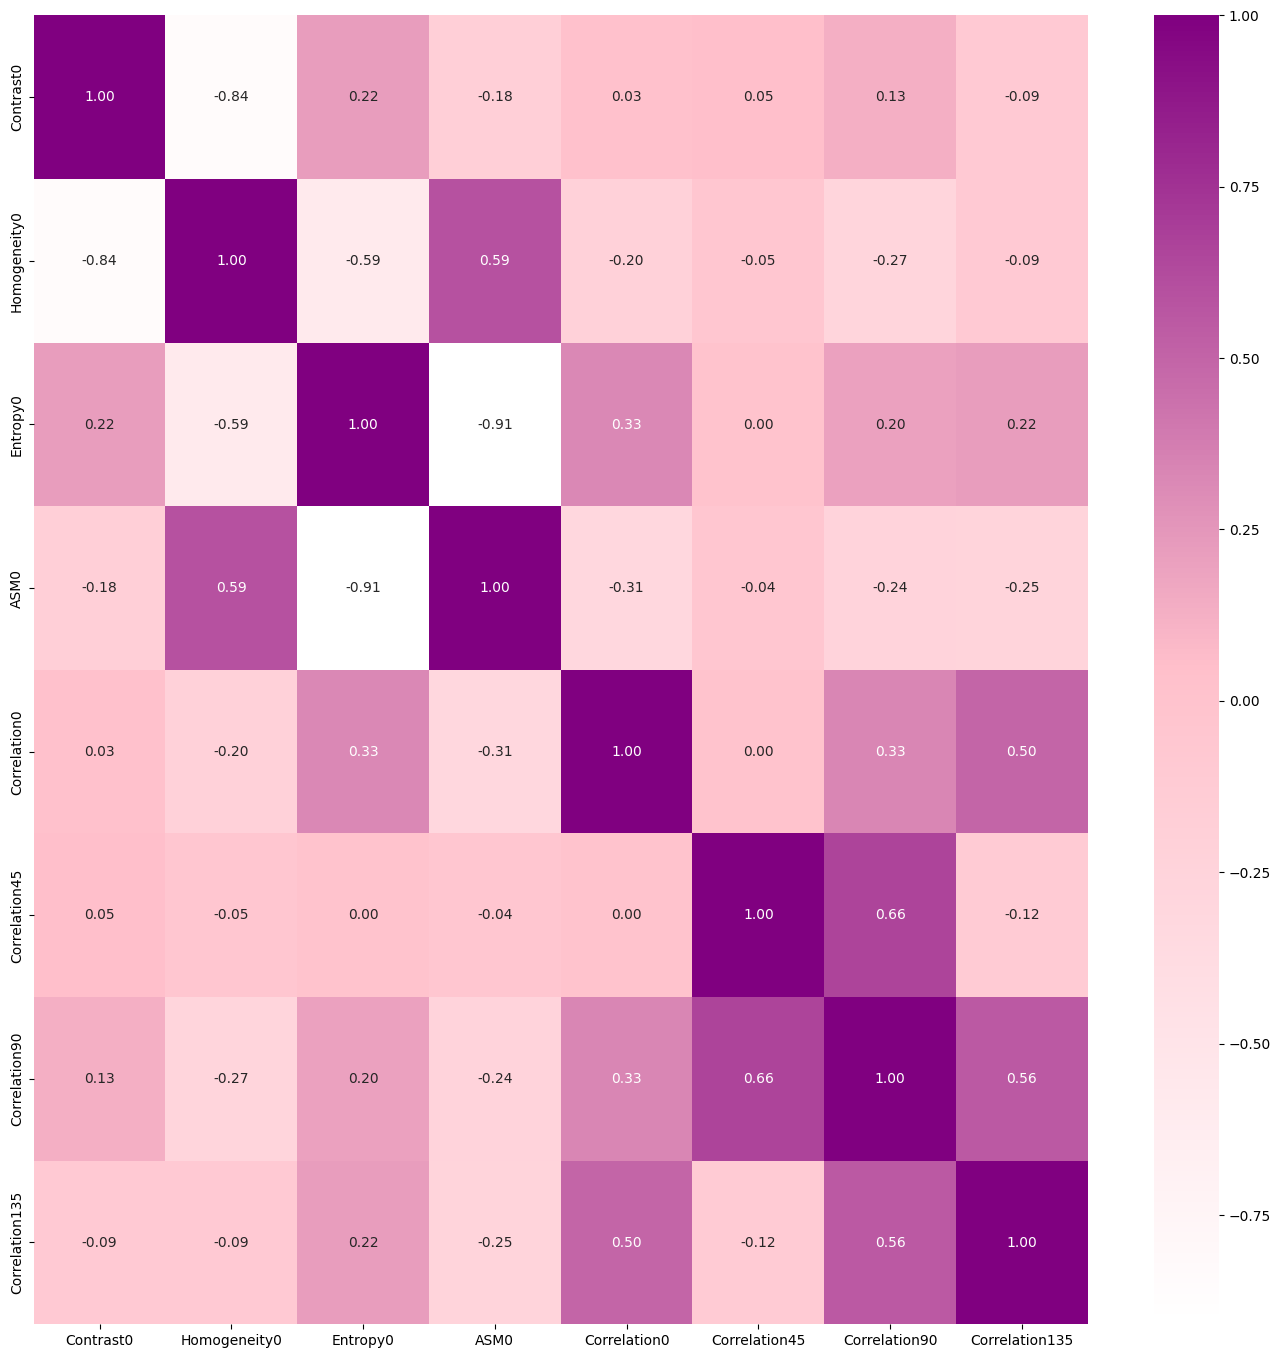

In [81]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [82]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 8)
(60, 8)


In [83]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [84]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [85]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.98      0.91      0.95        69
      Rosacea       0.92      0.99      0.95        71

     accuracy                           0.95       140
    macro avg       0.95      0.95      0.95       140
 weighted avg       0.95      0.95      0.95       140

[[63  6]
 [ 1 70]]
Accuracy: 0.95

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.62      0.77      0.69        31
      Rosacea       0.67      0.48      0.56        29

     accuracy                           0.63        60
    macro avg       0.64      0.63      0.62        60
 weighted avg       0.64      0.63      0.62        60

[[24  7]
 [15 14]]
Accuracy: 0.6333333333333333


In [86]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.76      0.75      0.76        69
      Rosacea       0.76      0.77      0.77        71

     accuracy                           0.76       140
    macro avg       0.76      0.76      0.76       140
 weighted avg       0.76      0.76      0.76       140

[[52 17]
 [16 55]]
Accuracy: 0.7642857142857142

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.62      0.65      0.63        31
      Rosacea       0.61      0.59      0.60        29

     accuracy                           0.62        60
    macro avg       0.62      0.62      0.62        60
 weighted avg       0.62      0.62      0.62        60

[[20 11]
 [12 17]]
Accuracy: 0.6166666666666667


In [87]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
               precision    recall  f1-score   support

Acne vulgaris       0.81      0.84      0.82        69
      Rosacea       0.84      0.80      0.82        71

     accuracy                           0.82       140
    macro avg       0.82      0.82      0.82       140
 weighted avg       0.82      0.82      0.82       140

[[58 11]
 [14 57]]
Accuracy: 0.8214285714285714

------Testing Set------
               precision    recall  f1-score   support

Acne vulgaris       0.67      0.65      0.66        31
      Rosacea       0.63      0.66      0.64        29

     accuracy                           0.65        60
    macro avg       0.65      0.65      0.65        60
 weighted avg       0.65      0.65      0.65        60

[[20 11]
 [10 19]]
Accuracy: 0.65


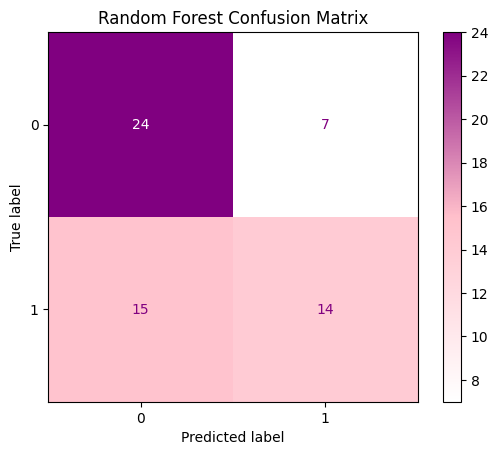

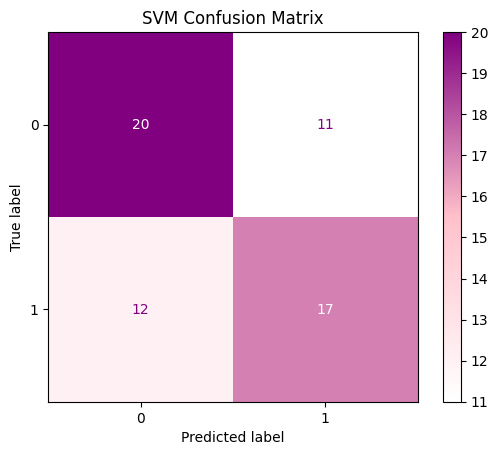

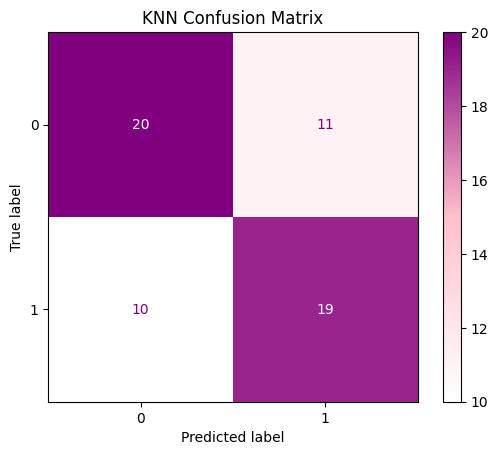

In [88]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")